In [413]:
#(thlu = theta leg upper, thll = theta leg lower)


%reset
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thlu,thll = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg_upper}','\\theta_{leg_lower}']) 
dx,dy,dthb,dthlu,dthll = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg_upper}','\dot{\\theta}_{leg_lower}']) 
ddx,ddy,ddthb,ddthlu,ddthll = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg_upper}','\ddot{\\theta}_{leg_lower}']) 

q = sym.Matrix([[x],[y],[thb],[thlu],[thll]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthlu],[dthll]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthlu],[ddthll]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
tau_hip,tau_knee,GRFx,GRFy = sym.symbols(['\\tau_hip','\\tau_knee','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - 0.5*ll1*sym.cos(thb + thlu)],
                [y - 0.5*ll1*sym.sin(thb + thlu)],
                [thb + thlu]])

rl2 = sym.Matrix([[x - ll1*sym.cos(thb + thlu)-(0.5*ll2)*sym.cos(thb + thlu+thll)],
                [y - ll1*sym.sin(thb + thlu)-(0.5*ll2)*sym.sin(thb + thlu+thll)],
                [thb + thlu+thll]])



# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau_hip]])
tau_l1 = sym.Matrix([[0],[0],[tau_hip - tau_knee]])
tau_l2 = sym.Matrix([[0],[0],[tau_knee]])

# F_l1 = sym.Matrix([[-F*sym.sin(thb+thlu)],[F*sym.cos(thb+thlu)],[0]])
# F_l2 = sym.Matrix([[+F*sym.cos(thb+thlu+thll)],[F*sym.sin(thb+thlu+thll)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[(0.5*ll2*sym.sin(thb+thlu+thll)*GRFx) - (0.5*ll2*sym.cos(thb+thlu+thll)*GRFy)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1).transpose()*Jl1[:,j]+(GRF_l2+tau_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [414]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thlu,thll,
            dx,dy,dthb,dthlu,dthll,
            ddx,ddy,ddthb,ddthlu,ddthll,
            tau_hip,tau_knee,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thlu = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_thll = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [415]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 100
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_lu','theta_ll'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)

In [416]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [417]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
#         L = 0.5*m.len[('leg',1)]  + 0.5*m.len[('leg',2)] # total leg length
#         thA = m.q[n,'theta_b'] + m.q[n,'theta_lu'] + m.q[n,'theta_ll'] # absolute leg angle
        thA=(m.q[n,'theta_b'] + m.q[n,'theta_lu'])
        thB=(m.q[n,'theta_b'] +m.q[n,'theta_lu']+ m.q[n,'theta_ll'])

        return m.footp[n,dof] ==  m.q[n,'y'] - (m.len[('leg',1)]*sin(thA))-(m.len[('leg',2)]*sin(thB))
        
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)

# lambdify the foot velocity
thA=(thb + thlu)
thB=(thb + thlu + thll)

#footx = sym.Matrix([x + (0.5*ll1+0.5*ll2)*sym.sin(thb + thlu + thll)])
footx = sym.Matrix([x - (ll1*sym.cos(thA))-(ll2*sym.cos(thB))])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

In [418]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# parameters
hip_bound = [0,np.pi]
m.hip_bound = Param(m.joint_constraints, initialize = {'up':hip_bound[1],'lo':hip_bound[0]}) 

knee_bound = [-np.pi/2,np.pi/2]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'theta_lu'].setlb(hip_bound[0])
    m.q[n,'theta_lu'].setub(hip_bound[1])
    m.q[n,'theta_ll'].setlb(hip_bound[0])
    m.q[n,'theta_ll'].setub(hip_bound[1])

# variables
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
m.tau_r1 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque

m.tau_b = Var(m.N, bounds = (-2,2)) # actuator torque at knee
m.tau_r2 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque


# m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
# m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# # complementarity
# def hip_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT angle
#             return m.joint_penalty[n,'hip',jc] == (m.hip_bound['up'] - m.q[n+1,'theta_lu']-m.q[n+1,'theta_ll'])*m.tau_r1[n,'ng']
#         else:
#             return m.joint_penalty[n,'hip',jc] == (m.q[n+1,'theta_lu'] + m.q[n+1,'theta_ll']- m.hip_bound['lo'])*m.tau_r1[n,'ps']
#     else:
#         return Constraint.Skip
# m.hip_limits = Constraint(m.N, m.joint_constraints, rule = hip_limits)

# def knee_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT distance
#             return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] )*m.F_r[n,'ng']
#         else:
#             return m.joint_penalty[n,'knee',jc] == ( - m.knee_bound['lo'])*m.F_r[n,'ps']
#     else:
#         return Constraint.Skip
# m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

# #bound contact forces at last node
# for sgn in signs:
#     m.F_r[N,sgn].value = 0
#     m.F_r[N,sgn].fixed = True

for sgn in signs:
    m.tau_r1[N,sgn].value = 0
    m.tau_r1[N,sgn].fixed = True
    m.tau_r2[N,sgn].value = 0
    m.tau_r2[N,sgn].fixed = True

In [419]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))       #time constraint
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:             #ground constraints
            penalty_sum += m.ground_penalty[n,gc] #ground constraints  
#         for jc in joint_constraints:              #hard stop constraints
#             for j in joints:                       #hard stop constraints
#                 penalty_sum += m.joint_penalty[n,j,jc] #hard stop constraints
    return T+1000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [420]:
# def CostFun(m):
#     torque_sum = 0
#     for n in range(1,N+1):
#             torque_sum += m.tau_a[n]**2
#     return torque_sum
# m.Cost = Objective(rule = CostFun)

In [421]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, rule = EOM_x)

def EOM_y(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, rule = EOM_y)

def EOM_thb(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, rule = EOM_thb)

def EOM_thlu(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thlu(*var_list) == 0
m.EOM_thlu = Constraint(m.N, rule = EOM_thlu)

def EOM_thll(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])    
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thll(*var_list) == 0
m.EOM_thll = Constraint(m.N, rule = EOM_thll)

In [422]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'y'].value = 30.0
m.q[1,'theta_b'].value = 0.0
m.q[1,'theta_lu'].value = np.pi/2
m.q[1,'theta_ll'].value = 0.0
m.ddq[1,'theta_b'].value = 0.0

for dof in DOFs:
    m.q[1,dof].fixed = True
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
 
    
for n in range(1,N+1):
#     m.F_a[n].value = 0.0
#     m.F_a[n].fixed = True
    m.tau_a[n].value = 0.0
    m.tau_a[n].fixed = True
    m.tau_b[n].value = 0.0
    m.tau_b[n].fixed = True

    
# m.q[N,'x'].value = 0.0
# m.q[N,'y'].value = 0.0
# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
    
m.pprint()


21 Set Declarations
    DOF : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'x', 'y', 'theta_b', 'theta_lu', 'theta_ll'}
    GRF_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain     : Size : Members
        None :     3 : N*WDOF*sgn :  600 : {(1, 'X', 'ps'), (1, 'X', 'ng'), (1, 'Y', 'ps'), (1, 'Y', 'ng'), (1, 'THETA', 'ps'), (1, 'THETA', 'ng'), (2, 'X', 'ps'), (2, 'X', 'ng'), (2, 'Y', 'ps'), (2, 'Y', 'ng'), (2, 'THETA', 'ps'), (2, 'THETA', 'ng'), (3, 'X', 'ps'), (3, 'X', 'ng'), (3, 'Y', 'ps'), (3, 'Y', 'ng'), (3, 'THETA', 'ps'), (3, 'THETA', 'ng'), (4, 'X', 'ps'), (4, 'X', 'ng'), (4, 'Y', 'ps'), (4, 'Y', 'ng'), (4, 'THETA', 'ps'), (4, 'THETA', 'ng'), (5, 'X', 'ps'), (5, 'X', 'ng'), (5, 'Y', 'ps'), (5, 'Y', 'ng'), (5, 'THETA', 'ps'), (5, 'THETA', 'ng'), (6, 'X', 'ps'), (6, 'X', 'ng'), (6, 'Y', 'ps'), (6, 'Y', 'ng'), (6, 'THETA', 'ps'), (6, 'THETA', 'ng'), (7, 'X', 'ps'), (7, 'X', 'ng'), 

         (23, 'THETA', 'ng') :   0.0 :  None :  None : False :  True :  Reals
         (23, 'THETA', 'ps') :   0.0 :  None :  None : False :  True :  Reals
             (23, 'X', 'ng') :   0.0 :  None :  None : False :  True :  Reals
             (23, 'X', 'ps') :   0.0 :  None :  None : False :  True :  Reals
             (23, 'Y', 'ng') :   0.0 :  None :  None : False :  True :  Reals
             (23, 'Y', 'ps') :   0.0 :  None :  None : False :  True :  Reals
         (24, 'THETA', 'ng') :   0.0 :  None :  None : False :  True :  Reals
         (24, 'THETA', 'ps') :   0.0 :  None :  None : False :  True :  Reals
             (24, 'X', 'ng') :   0.0 :  None :  None : False :  True :  Reals
             (24, 'X', 'ps') :   0.0 :  None :  None : False :  True :  Reals
             (24, 'Y', 'ng') :   0.0 :  None :  None : False :  True :  Reals
             (24, 'Y', 'ps') :   0.0 :  None :  None : False :  True :  Reals
         (25, 'THETA', 'ng') :   0.0 :  None :  None : False :  

         76 :    -2 :   0.0 :     2 :  True :  True :  Reals
         77 :    -2 :   0.0 :     2 :  True :  True :  Reals
         78 :    -2 :   0.0 :     2 :  True :  True :  Reals
         79 :    -2 :   0.0 :     2 :  True :  True :  Reals
         80 :    -2 :   0.0 :     2 :  True :  True :  Reals
         81 :    -2 :   0.0 :     2 :  True :  True :  Reals
         82 :    -2 :   0.0 :     2 :  True :  True :  Reals
         83 :    -2 :   0.0 :     2 :  True :  True :  Reals
         84 :    -2 :   0.0 :     2 :  True :  True :  Reals
         85 :    -2 :   0.0 :     2 :  True :  True :  Reals
         86 :    -2 :   0.0 :     2 :  True :  True :  Reals
         87 :    -2 :   0.0 :     2 :  True :  True :  Reals
         88 :    -2 :   0.0 :     2 :  True :  True :  Reals
         89 :    -2 :   0.0 :     2 :  True :  True :  Reals
         90 :    -2 :   0.0 :     2 :  True :  True :  Reals
         91 :    -2 :   0.0 :     2 :  True :  True :  Reals
         92 :    -2 :   

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          : Upper : Active
   

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key        : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                    : Upper : Active
          (1, 'X') :   0.0 :                                       footv[1,X,ps] - footv[1,X,ng] - (0.5*dq[1,theta_ll]*sin(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + dq[1,x] + dq[1,theta_lu]*(0.5*sin(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + 0.5*sin(q[1,theta_lu] + q[1,theta_b])) + dq[1,theta_b]*(0.5*sin(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + 0.5*sin(q[1,theta_lu] + q[1,theta_b]))) :   0.0 :   True
          (2, 'X') :   0.0 :                                       footv[2,X,ps] - footv[2,X,ng] - (0.5*dq[2,theta_ll]*sin(q[2,theta_lu] + q[2,theta_ll] + q

        Key : Lower : Body                                                        : Upper : Active
          1 :   0.0 :       ground_penalty[1,slip_ng] - footv[1,X,ng]*GRF[1,X,ng] :   0.0 :   True
          2 :   0.0 :       ground_penalty[2,slip_ng] - footv[2,X,ng]*GRF[2,X,ng] :   0.0 :   True
          3 :   0.0 :       ground_penalty[3,slip_ng] - footv[3,X,ng]*GRF[3,X,ng] :   0.0 :   True
          4 :   0.0 :       ground_penalty[4,slip_ng] - footv[4,X,ng]*GRF[4,X,ng] :   0.0 :   True
          5 :   0.0 :       ground_penalty[5,slip_ng] - footv[5,X,ng]*GRF[5,X,ng] :   0.0 :   True
          6 :   0.0 :       ground_penalty[6,slip_ng] - footv[6,X,ng]*GRF[6,X,ng] :   0.0 :   True
          7 :   0.0 :       ground_penalty[7,slip_ng] - footv[7,X,ng]*GRF[7,X,ng] :   0.0 :   True
          8 :   0.0 :       ground_penalty[8,slip_ng] - footv[8,X,ng]*GRF[8,X,ng] :   0.0 :   True
          9 :   0.0 :       ground_penalty[9,slip_ng] - footv[9,X,ng]*GRF[9,X,ng] :   0.0 :   True
         1

        Key               : Lower : Body                                                              : Upper : Active
           (2, 'theta_b') :   0.0 :           q[2,theta_b] - (q[1,theta_b] + 0.02*h[2]*dq[2,theta_b]) :   0.0 :   True
          (2, 'theta_ll') :   0.0 :        q[2,theta_ll] - (q[1,theta_ll] + 0.02*h[2]*dq[2,theta_ll]) :   0.0 :   True
          (2, 'theta_lu') :   0.0 :        q[2,theta_lu] - (q[1,theta_lu] + 0.02*h[2]*dq[2,theta_lu]) :   0.0 :   True
                 (2, 'x') :   0.0 :                             q[2,x] - (q[1,x] + 0.02*h[2]*dq[2,x]) :   0.0 :   True
                 (2, 'y') :   0.0 :                             q[2,y] - (q[1,y] + 0.02*h[2]*dq[2,y]) :   0.0 :   True
           (3, 'theta_b') :   0.0 :           q[3,theta_b] - (q[2,theta_b] + 0.02*h[3]*dq[3,theta_b]) :   0.0 :   True
          (3, 'theta_ll') :   0.0 :        q[3,theta_ll] - (q[2,theta_ll] + 0.02*h[3]*dq[3,theta_ll]) :   0.0 :   True
          (3, 'theta_lu') :   0.0 :        q[3,t

        Key               : Lower : Body                                                                : Upper : Active
           (2, 'theta_b') :   0.0 :          dq[2,theta_b] - (dq[1,theta_b] + 0.02*h[2]*ddq[1,theta_b]) :   0.0 :   True
          (2, 'theta_ll') :   0.0 :       dq[2,theta_ll] - (dq[1,theta_ll] + 0.02*h[2]*ddq[1,theta_ll]) :   0.0 :   True
          (2, 'theta_lu') :   0.0 :       dq[2,theta_lu] - (dq[1,theta_lu] + 0.02*h[2]*ddq[1,theta_lu]) :   0.0 :   True
                 (2, 'x') :   0.0 :                            dq[2,x] - (dq[1,x] + 0.02*h[2]*ddq[1,x]) :   0.0 :   True
                 (2, 'y') :   0.0 :                            dq[2,y] - (dq[1,y] + 0.02*h[2]*ddq[1,y]) :   0.0 :   True
           (3, 'theta_b') :   0.0 :          dq[3,theta_b] - (dq[2,theta_b] + 0.02*h[3]*ddq[2,theta_b]) :   0.0 :   True
          (3, 'theta_ll') :   0.0 :       dq[3,theta_ll] - (dq[2,theta_ll] + 0.02*h[3]*ddq[2,theta_ll]) :   0.0 :   True
          (3, 'theta_lu') :   0.

In [182]:
# # INITIALIZE ----------------------------------------------------------------------------------------------------------------
# guide = np.linspace(0,5.0,N)
# for n in range(1,N+1):
#     m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#     m.q[n,'y'].value  = np.random.uniform(0,3)
#     m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/2,np.pi/2)
#     m.q[n,'theta_lu'].value  = np.random.uniform(0,np.pi)
#     m.q[n,'theta_ll'].value  = np.random.uniform(-np.pi/2,np.pi/2)
    
#     m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#     m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value

In [166]:
# # SPRINT --------------------------------------------------------------------------------------------------------------------
# # tax day

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_lu'].value = np.pi/2
# m.q[1,'theta_ll'].value = 0.0

# m.q[1,'x'].fixed = True
# m.q[1,'theta_b'].fixed = True
# m.q[1,'theta_lu'].fixed = True
# m.q[1,'theta_ll'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
      
# # final condition
# m.q[N,'x'].setlb(5.0)

# m.dq[N,'x'].value = 0.0
# m.dq[N,'x'].fixed = 0.0
# m.dq[N,'theta_b'].value = 0.0
# m.dq[N,'theta_b'].fixed = 0.0
# m.dq[N,'theta_lu'].value = 0.0
# m.dq[N,'theta_lu'].fixed = 0.0
# m.dq[N,'theta_ll'].value = 0.0
# m.dq[N,'theta_ll'].fixed = 0.0

# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
# m.q[N,'theta_b'].fixed = True
# m.q[N,'theta_lu'].fixed = True
# m.q[N,'theta_ll'].fixed = True

# m.footp[N,'Y'].value = 0.0
# m.footp[N,'Y'].fixed = True
    
# #m.pprint()

In [423]:
# solving
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Yousuf/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.12.12: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    13784
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5933

Total number of variables............................:     3083
                     variables with only lower bounds:     1592
                variables with lower and upper bounds:      298
                     variables with only 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.8271978e+02 1.04e-10 8.44e+01  -1.0 9.82e-03    -  1.00e+00 1.00e+00h  1
 101  1.2939206e+02 3.92e-04 2.68e+05  -5.7 6.41e-01    -  9.19e-01 9.46e-01f  1
 102  8.6606953e+01 5.92e-03 1.99e+05  -5.7 2.30e+00    -  7.09e-01 9.31e-01f  1
 103  8.3525705e+01 8.40e-03 1.30e+04  -5.7 4.83e+00    -  8.69e-01 5.23e-01f  1
 104  8.1027086e+01 8.46e-03 1.96e+04  -5.7 4.95e+00    -  1.96e-01 7.04e-01f  1
 105  8.0231888e+01 2.95e-03 1.98e+03  -5.7 3.57e+00    -  8.64e-01 7.37e-01f  1
 106  8.0079214e+01 1.08e-03 6.85e+02  -5.7 1.21e+01    -  6.47e-01 6.36e-01h  1
 107  8.0020656e+01 3.74e-04 7.41e+02  -5.7 1.93e+01    -  3.71e-01 7.87e-01f  1
 108  8.0005428e+01 4.86e-04 4.48e+02  -5.7 3.18e+01    -  9.03e-01 1.00e+00f  1
 109  8.0005121e+01 9.48e-04 3.19e+03  -5.7 3.25e+02    -  1.00e+00 6.89e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.0002542e+01 5.37e-04

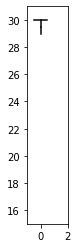

In [424]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,2])
    ax.set_ylim([15,31])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('leg',1)]*cos(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*sin(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB= m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value+m.q[i,'theta_ll'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb-m.len[('leg',2)]*cos(thB)    
    leg2_yb = leg1_yb-m.len[('leg',2)]*sin(thB)     
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [428]:
for n in range(1,N+1):
    print(m.ddq[n,'theta_b'].value)
print(m.ddq[1,'theta_b'].value)

3.8440558630425055
1.616028413164858
1.1890818828867673
0.9938542788098217
0.8788194094864394
0.8020352312508688
0.7468390326212654
0.7051764779970809
0.6726345221496361
0.6465740201844938
0.62531110334403
0.6077164958159642
0.5930023418031201
0.580601116080107
0.5700931043944958
0.5611610330209806
0.5535606225111022
0.5471008690739346
0.5416304786188088
0.5370283113684385
0.5331965106237783
0.5300554703331907
0.5275400888255803
0.5255969391525297
0.5241821038629464
0.5232594989727214
0.5227995633444209
0.5227782247318902
0.5231760780065627
0.523977728139161
0.5251712626716755
0.5267478271989288
0.528701283802975
0.5310279371366725
0.5337263164099962
0.5367970042258879
0.5402425052760658
0.5440671495088821
0.5482770256430224
0.5528799419113632
0.5578854117453323
0.5633046628013652
0.5691506683262758
0.575438200387369
0.5821839049807578
0.5894063994976443
0.5971263934915635
0.6053668341661729
0.6141530785094892
0.6235130945530946
0.6334776948522196
0.6440808059851254
0.6553597786818979


In [427]:
sym.printing.latex(EOM[1].simplify())

'- 1.0 G_{y} - 0.5 \\ddot{\\theta}_{body} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{body} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{body} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_lower} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} + 1.0 \\ddot{y} m_{body} + 1.0 \\ddot{y} m_{leg1} + 1.0 \\ddot{y} m_{leg2} + 0.5 \\dot{\\theta}_{body}^{2} l_{leg1} m_{leg1} \\sin{\\left(\\theta_{body}